In [35]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
import flax
from typing import Any
import numpy as np

# Optimization

Within the umbrella of gradient descent, there are many varieties of strategies we can choose from. We usually refer these update choices as **optimizers**, which often take the form of modifying the gradient in some way to stabilize learning.

## Gradient Descent

The simplest optimization strategy is just **gradient descent**. The idea is to iteratively query the gradient, then update the parameters to move slightly in that direction. Remember that we want to minimize loss, so we want to move in the *negative* direction of the gradient.

Gradients represent the *first-order* behavior of the function, so gradients are only accurate around a local neighborhood of the parameters. A nice analogy is to think about descending down a parabola by moving in its tangent line. The tangent is constantly changing, so we need to keep re-calculating our gradient as we update the parameters.

```python
# Gradient Descent
grads = grad(params, x, y)
params = params - grads 
```

Note that the larger of a step we take, the more inaccurate our gradient direction is. To accomodate for this, we will use a small **learning rate** and scale down our gradient accordingly.
```python
# Gradient Descent with learning rate.
grads = grad(params, x, y)
params = params - grads * lr 
```


## Example: Quadratic loss function

```{margin}
**Isn't the optimal answer just $x=0$?** For our setting, yes. Usually quadratic loss is posed as $L(x) = x^TQx - b^Tx$, and the optimal point is at $Q^{-1}b$. But we can always use change-of-variables to make the gradient dynamics the same, e.g. $y = x - Q^{-1}b$. For ease of analysis, we'll use the simpler equation with only $Q$.
```

To understand some dynamics about gradient descent, let's take a look at a simple example. We'll look at a simple **quadratic loss** function, a classic example in optimization. We are given a loss function paramterized by $Q$ such that $L(x) = x^TQx$, and we look to find $x$ that minimizes the loss. We'll use a $(2,2)$ matrix $Q$, so $x$ is a 2-dimensional vector.

Let's examine some simple runs of gradient descent. The key here is to demonstrate that *even for very simple functions*, choosing the correct learning rate is important. Remember that our learning rate is intuitively defines a local neighborhood over parameters where we assume our gradient is correct. 

In [36]:
def plot_optim(optim):
    theta = np.pi / 16
    eigenvalues = np.array([1, 6])
    Q = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]) @ np.diag(eigenvalues) @ np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

    @jax.vmap
    def quadratic_loss(v):
        return v.T @ Q @ v

    iter_points = []
    z = np.array([9.5, -1])
    for i in range(50):
        iter_points.append(z)
        grad_z = Q @ z
        z = optim(z, grad_z)

    # Create a grid of points
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-4, 4, 100)
    X, Y = np.meshgrid(x, y)
    XY = np.stack([X.flatten(), Y.flatten()], axis=-1)
    Z = quadratic_loss(XY)
    Z = Z.reshape(X.shape)

    # Create the plot
    plt.figure(figsize=(10, 4))
    contour = plt.contour(X, Y, Z, levels=50, cmap='viridis', alpha=0.4)
    plt.clabel(contour, inline=True, fontsize=8)


    iter_points = np.array(iter_points)
    plt.plot(iter_points[:, 0], iter_points[:, 1], 'ro-')
    plt.xticks([])
    plt.yticks([])
    plt.show()

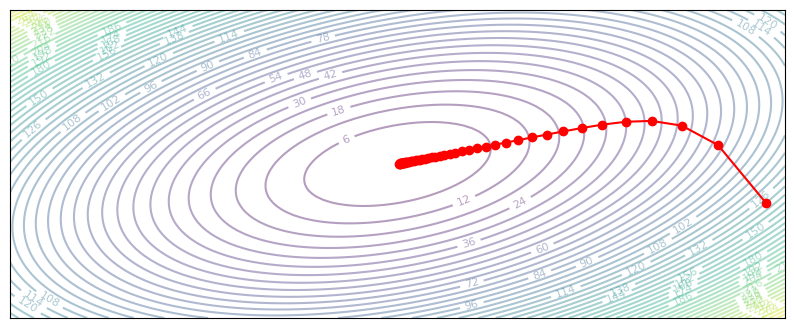

In [37]:
def gradient_descent(z, grad_z):
    return z - 0.1 * grad_z
plot_optim(gradient_descent)

If our learning rate is too low, the network will take a long time to reach the minimum point. Slow convergence is especially true for quadratic loss functions (and mean-squared-error in deep learning), as the gradient magnitude approaches zero along with the loss. 

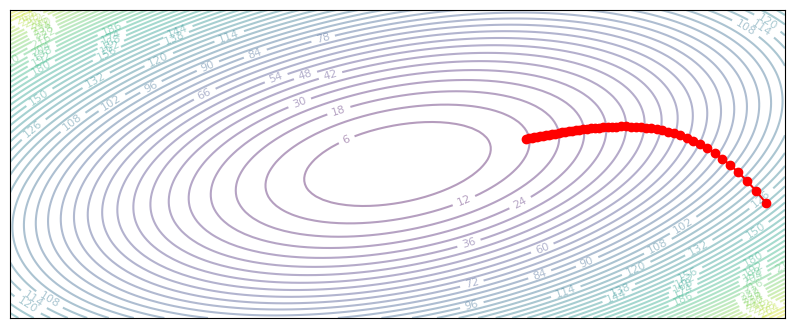

In [38]:
def gradient_descent_slow(z, grad_z):
    return z - 0.02 * grad_z
plot_optim(gradient_descent_slow)

On the other hand, a high learning rate means we will overshoot our optimal parameters. If the update overshoots but still ends up at a lower loss, network will still eventually converge, but will oscillate between directions and have an overall slower convergence. If the update overshoots by too much, the parameters will completely diverge and approach infinity. Both of these are not great.

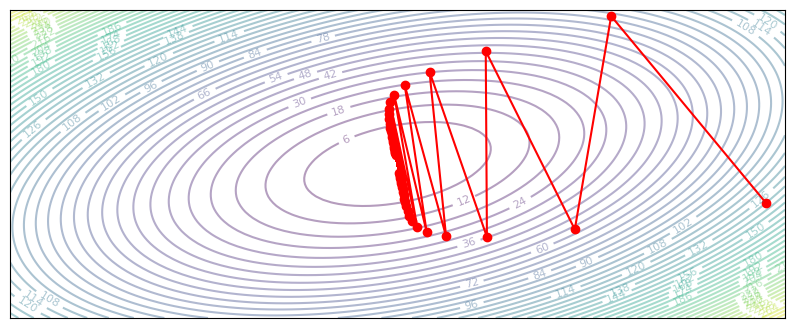

In [39]:
def gradient_descent_oscillate(z, grad_z):
    return z - 0.325 * grad_z
plot_optim(gradient_descent_oscillate)

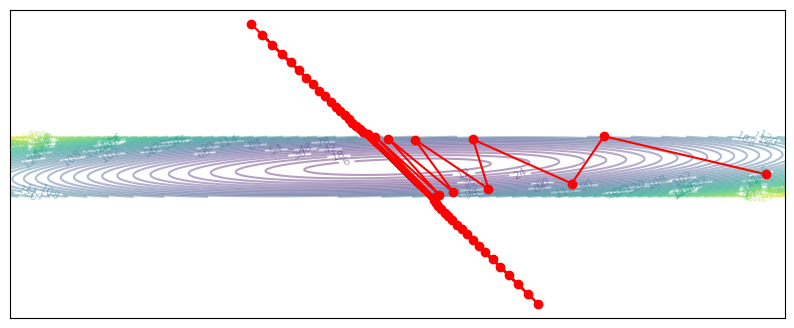

In [40]:
def gradient_descent_diverge(z, grad_z):
    return z - 0.34 * grad_z
plot_optim(gradient_descent_diverge)

## Learning rate in terms of eigenvalues

For our simple quadratic loss function, we can actually identify the exact optimal learning rate. Let's start by examining our cost matrix Q. We've defined Q to be a `2x2` matrix, with eigenvalues `1` and `6`.

We can rewrite $Q$ as $R \Sigma R^T$ equivalently, where $R$ contains the two eigenvectors of $Q$.

In [41]:
theta = np.pi / 16
eigenvalues = np.array([1, 6])
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
Q = R @ np.diag(eigenvalues) @ R.T

eigenvalues, eigenvectors = np.linalg.eig(Q)

print('Q:', Q)
print('Eigenvalues:', eigenvalues)
print('Eigenvectors (R):', eigenvectors)

Q: [[ 1.19030117 -0.95670858]
 [-0.95670858  5.80969883]]
Eigenvalues: [1. 6.]
Eigenvectors (R): [[-0.98078528  0.19509032]
 [-0.19509032 -0.98078528]]


This decomposition will give us a clearer look at what gradient descent is doing at each step. We'll use $y = R^Tx$ to represent a rotation of $x$ onto the eigenvector space:

$$
\begin{align}
x' & = x - \alpha \nabla x^T Q x \\
& = x - \alpha Q x \\
& = x - \alpha R \Lambda R^T x \\
& = Ry - \alpha R \Lambda R^T Ry \\
& = R(y - \alpha \Lambda y) \\
& = R (I - \alpha \Lambda) y.
\end{align}
$$

```{margin}
**Does this analysis hold for quadratic losses with a non-zero optimum?** Yes, it still does. In that case, $y$ should be the rotation of the *difference* between $x$ and the optimal $x^*$. This distance decreases exponentially.
```

Look at that! When we rotate $x$ onto the eigenvector space of $Q$, we get a simple formula -- each component of $y$ decreases exponentially by the rate of $(1 - \alpha \lambda)$. Each component *independently* decreases, regardless of the status of the other components in the vector. We can view the total loss as the sum of these components, squared and scaled by its equivalent eigenvalue.

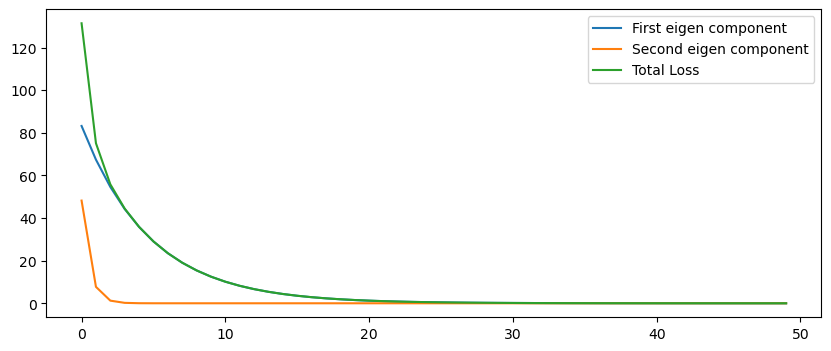

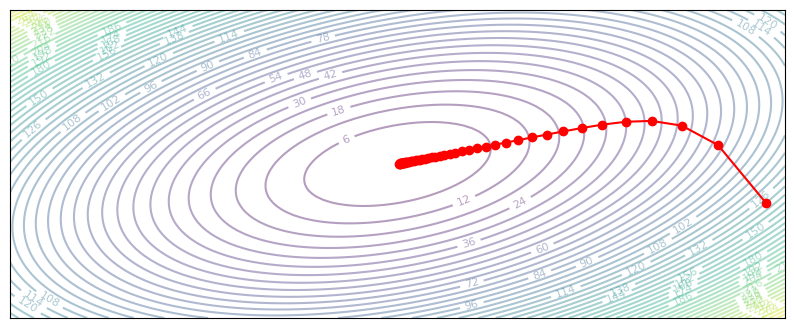

In [42]:
ys = []
loss = []
x = np.array([9.5, -1])
for i in range(50):
    ys.append(eigenvectors.T @ x)
    loss.append(x.T @ Q @ x)
    grad_x = Q @ x
    x = x - 0.1 * grad_x

# Plot the trajectory
ys = np.array(ys)
plt.figure(figsize=(10, 4))
loss_1 = np.square(ys[:, 0]) * np.abs(eigenvalues[0])
loss_2 = np.square(ys[:, 1]) * np.abs(eigenvalues[1])
plt.plot(loss_1, label='First eigen component')
plt.plot(loss_2, label='Second eigen component')
plt.plot(loss, label='Total Loss')
plt.legend()
plt.show()

def gradient_descent(z, grad_z):
    return z - 0.1 * grad_z
plot_optim(gradient_descent)

**Fig Above**: In our quadratic cost function, each eigenvector is an axis of the ellipse. The orange curve represents our point quickly approaching the wide axis, then the blue curve shows our point slowly converging along the second axis.

How can we find the **optimal learning rate** which will let us converge the fastest? We want to reach $y=0$ (and therefore $x=0$) to minimize loss, so we are bounded by the slowest moving component of $y$. Remember that each component exponentially decreases by $ |1 - \alpha \lambda|$.

The constraint is therefore as follows. Among all components, we want the slowest rate $|1 - \alpha \lambda|$ to be the maximum value it can be (so we learn fast), *without* letting any $ |1 - \alpha \lambda|$ be greater than one (or we will diverge). For our $Q$ matrix, this means our learning rate should be:

In [43]:
print('Optimal LR is', 2 / (np.max(eigenvalues) + np.min(eigenvalues)))

Optimal LR is 0.2857142857142857


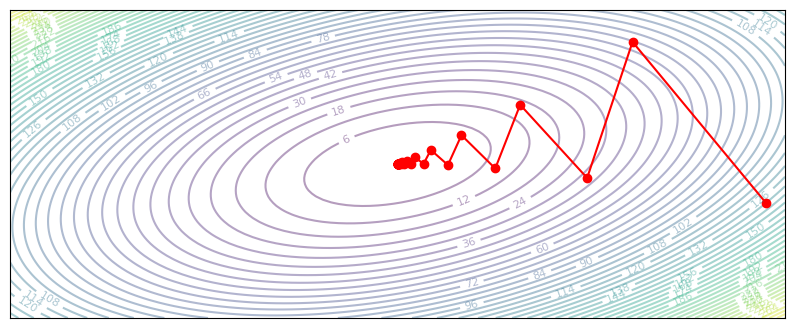

In [44]:
def gradient_descent(z, grad_z):
    return z - 0.28 * grad_z
plot_optim(gradient_descent)

## Preconditioning

In the above section, we had to make compromises on our learning rate because we asserted that learning rate was a global scalar. We can generalize the notion of a learning rate to more complicated functions. **Preconditioned gradient descent** assumes some matrix $P$ which we'll use to transform our gradient:

$$
\theta \leftarrow \theta + \alpha P \nabla_\theta \; L(\theta)
$$

If $P$ is a diagonal matrix, we can view preconditioning as having a separate learning rate for each coordinate of $x$. In our quadratic loss, the horizontal dimension is more stretched out, so we could try using a higher learning rate there:

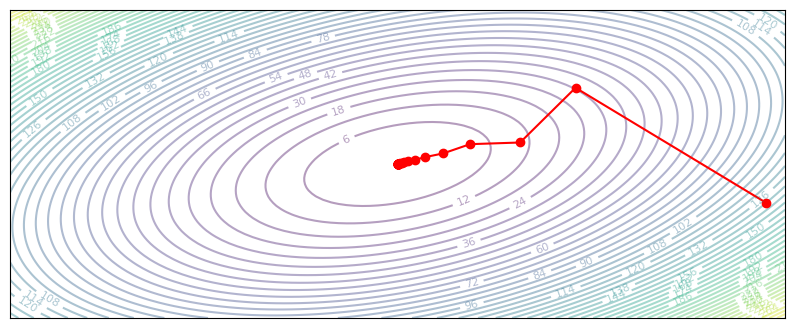

In [45]:
def diagonal_gradient_descent(z, grad_z):
    P = np.diag([2, 1])
    return z - 0.2 * P @ grad_z
plot_optim(diagonal_gradient_descent)

But really, $P$ lets us apply *any linear transformation* to the gradient. For our quadratic case, we actually know the 'ideal' transformation to use. Remember that each gradient update has a natural decomposition onto the eigenvector bases of $Q$. So, we can find a $P$ which rotates the gradient onto the eigenvalue basis of $Q$, then apply the maximum learning rate for each eigen component.

Recall that error for each eigen component decreases with a multplier of $|1 - \alpha \lambda|$, so for the **maximum per-coordinate learning rate** we want this multiplier to be close to zero, i.e. $\alpha = 1 / \lambda$.

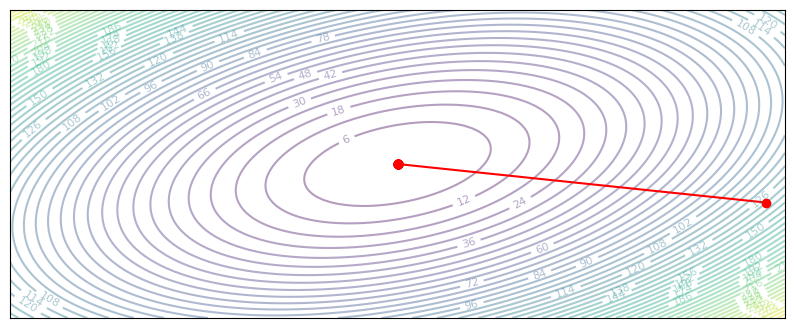

In [46]:
def preconditioned_gradient_descent(z, grad_z):
    P = eigenvectors @ np.diag(1/eigenvalues) @ eigenvectors.T
    return z - 1 * P @ grad_z
plot_optim(preconditioned_gradient_descent)

With the analytically ideal preconditioning matrix, we can point *directly* to the solution, and arrive there in a single gradient step. One-step solution is a special property of quadratic loss functions, and should not be expected to generalize to more complicated losses. That said, preconditioning is a powerful tool that gives us a more accuate gradient direction. It turns out that preconditioning relates directly to **second-order descent methods**, which we'll cover in a future section [].

## Descent on Neural Networks

To apply gradient descent to real neural networks, we'll basically follow the same procedures as above, with two key differences.

The first difference is we won't have a closed-form equation for our loss function. In machine learning we'll typically have a large dataset of `x, y` pairs, and define our loss function to minimize some prediction error over `y`. This dataset is often so big that it's unreasonable to try and calculate predictions over the entire dataset at once. Instead, we can sample random pairs from the dataset, and optimize the approximate loss we get from these pairs. This algorithm, known as **stochastic gradient descent (SGD)**, gives us an estimate of the true gradient at each step. 

```python
x_batch, y_batch = sample(x, y)
grads = grad(params, x_batch, y_batch)
params = params - grads * lr # Stochastic Gradient Descent
```

The second difference is that for multi-layer systems, training dynamics for each layer change as the *other layers are updated*. In the quadratic example above we knew how to find an optimal learning rate, and even an optimal preconditioning matrix. This won't be true for neural network training, since each layer depends on the other layers, it's even more critical to use an iterative procedure.

Let's try out our simple SGD algorithm on a standard task, **MNIST classification**. The MNIST dataset is a set of handwritten numerical digits, represented as 28x28 matrices. We'll collapse each matrix into a 784-length vector, then train a three-layer neural network to classify each digit. 

Dataset size: (60000, 28, 28)


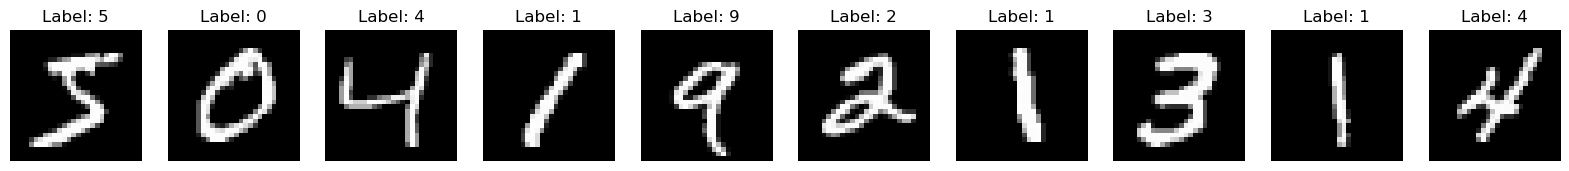

In [47]:
from keras.datasets import mnist
(train_images, train_labels), (valid_images, valid_labels) = mnist.load_data()
print('Dataset size:', train_images.shape)

fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.imshow(train_images[i], cmap='gray')
    ax.title.set_text(f'Label: {train_labels[i]}')
    ax.axis('off')

In [48]:
class Classifier(nn.Module):
    features: int = 512
    num_classes: int = 10

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.features)(x)
        x = nn.relu(x)
        x = nn.Dense(self.features)(x)
        x = nn.relu(x)
        x = nn.Dense(self.num_classes)(x)
        return x

def sample_batch(key, batchsize, images, labels):
    idx = jax.random.randint(key, (batchsize,), 0, images.shape[0])
    return jnp.reshape(images[idx], (batchsize, -1)), labels[idx]

def learn_mnist(update_fn, init_opt_state):
    train_losses, valid_losses = [], []
    classifier = Classifier()
    key = jax.random.PRNGKey(0)
    key, param_key = jax.random.split(key)
    images, labels = sample_batch(param_key, 256, train_images, train_labels)
    v_images, v_labels = sample_batch(jax.random.PRNGKey(1), 1024, valid_images, valid_labels)
    params = classifier.init(param_key, images)['params']
    opt_state = init_opt_state(params)
    loss_fn = jax.jit(lambda p, x, y: jnp.mean(nn.log_softmax(classifier.apply({'params': p}, x)) * -jnp.eye(10)[y]))
    grad_fn = jax.jit(jax.value_and_grad(loss_fn))
    for i in range(1000):
        key, data_key = jax.random.split(key)
        images, labels = sample_batch(data_key, 256, train_images, train_labels)
        loss, grads = grad_fn(params, images, labels)
        params, opt_state = update_fn(params, grads, opt_state, i)
        train_losses.append(loss)
        valid_losses.append(loss_fn(params, v_images, v_labels))
        # if i % 100 == 0:
        #     print(f'Iteration {i}, Train Loss: {train_losses[-1]}, Valid Loss: {valid_losses[-1]}')
    
    fig, axs = plt.subplots(1, figsize=(4, 2))
    axs.plot(train_losses, label='Train Loss')
    axs.plot(valid_losses, label='Valid Loss')
    axs.legend()
    plt.show()
    print('Loss is below 0.15 at iteration', np.min(np.where(np.array(valid_losses) < 0.15)))

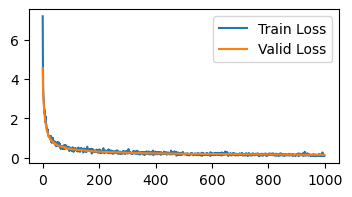

Loss is below 0.15 at iteration 828


In [49]:
def sgd(params, grads, opt_state, step):
    return jax.tree_map(lambda p, g: p - 0.001 * g, params, grads), None
init_opt_state = lambda p: None
learn_mnist(sgd, init_opt_state)

## Adaptive Learning Rate (Adagrad)

In the quadratic example, we saw how we can get faster convergence by using different learning rates per coordinate. **Adagrad** gives us a method of doing the same for deep neural networks. Adagrad can be seen as a preconditioned gradient descent method, where $P$ is a diagonal matrix. In other words, we will use an independent learning rate for *each parameter* in our network.

Recall the core issue -- some parameters affect the loss more than others. We want to normalize for this. Adagrad achieves this by keeping track of **per-parameter gradient variance**. When taking each gradient step, we will divide the gradient elementwise by these historical variances.

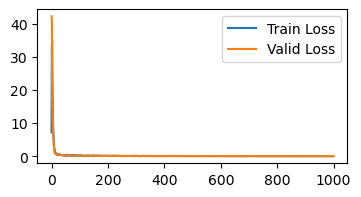

Loss is below 0.15 at iteration 171


In [50]:
@jax.jit
def adagrad(params, grads, variances, step):
    scaled_grads = jax.tree_map(lambda g, v: g / (jnp.sqrt(v + 1e-3)), grads, variances)
    new_params = jax.tree_map(lambda p, g: p - 0.001 * g, params, scaled_grads)
    new_variances = jax.tree_map(lambda v, g: v + g ** 2, variances, grads)
    return new_params, new_variances
init_variances = lambda p: jax.tree_map(lambda x: jnp.zeros_like(x), p)
learn_mnist(adagrad, init_variances)

## Momentum

Variance in our gradient direction can come from two main sources. First, the nature of stochastic gradient descent means we sample a new batch every update, which can be seen as adding noise to our gradient. Second, updates that are too large can result in oscillations in gradient direction.

To reduce these variances, we can condition our update not just on the current batch, but also an average of *past* gradients, which we call **momentum**. This technique is also known as the *heavy ball method*, as it resembles our parameters having mass that maintains past directions. 

A simple way to implement momentum is to keep track of an exponential moving average of the gradient by introducing a new momentum state $m$:

$$
m' \leftarrow \beta m + \nabla L(\theta) \\
\theta' \leftarrow x' - \alpha m'
$$

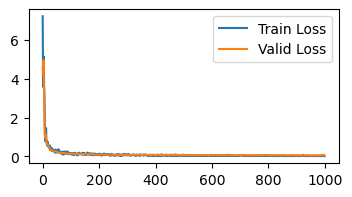

Loss is below 0.15 at iteration 83


In [51]:
@jax.jit
def momentum_update(params, grads, momentum, step):
    new_momentum = jax.tree_map(lambda m, g: 0.9 * m + g, momentum, grads)
    new_params = jax.tree_map(lambda p, g: p - 0.001 * g, params, new_momentum)
    return new_params, new_momentum
init_momentum = lambda m: jax.tree_map(lambda x: jnp.zeros_like(x), m)
learn_mnist(momentum_update, init_momentum)

## Adam

The most frequently used optimizer today is **Adam**, which combines insights from adaptive learning rates and momentum. Adam uses an exponential moving average to keep track of both past gradients (i.e. momentum) and past gradient *variances* (as we did in Adagrad):

$$
\begin{align}
m' & \leftarrow \beta_1 m + (1-\beta_1) \nabla L(\theta) \\
s' & \leftarrow \beta_2 s + (1-\beta_2) (\nabla L(\theta))^2
\end{align}
$$

Notice that the equations are slightly different then in Adagrad or momentum. The point of these changes is to keep the scales of the momentum and variance estimates consistent. Adagrad has a problem where keeping track of the sum of historical variances will rapidly go to infinity. Our simple momentum implementation is also weird, as the momentum magnitude will converge to approximately $1/(1-\beta)$. Instead, we would like to keep magnitudes normalized.

Because we initialize $m$ and $s$ to zero, at the beginning of training our estimates are closer to zero than we would like. Thus, in Adam we account for this and scale $m$ and $s$ by a scalar depending on training step:

$$
\hat{m_t} = m_t / (1-\beta^t_1) \quad \text{and} \quad \hat{s_t} = s_t / (1-\beta^t_2) \\
\theta \leftarrow \theta - \alpha m / (\sqrt{s} + \epsilon)
$$

where $\beta^t$ represents $\beta$ to the power $t$.

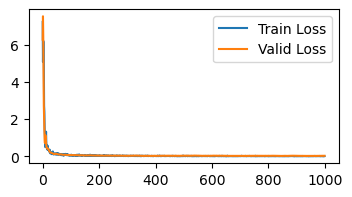

Loss is below 0.15 at iteration 36


In [52]:
@jax.jit
def adam_update(params, grads, opt_state, step):
    momentum, variance = opt_state
    b1, b2 = 0.9, 0.999
    new_momentum = jax.tree_map(lambda m, g: b1 * m + (1-b1) * g, momentum, grads)
    new_variance = jax.tree_map(lambda v, g: b2 * v + (1-b2) * g ** 2, variance, grads)
    m_hat = jax.tree_map(lambda m: m / (1 - b1 ** (step + 1)), new_momentum)
    v_hat = jax.tree_map(lambda v: v / (1 - b2 ** (step + 1)), new_variance)
    update = jax.tree_map(lambda m, v: m / (jnp.sqrt(v) + 1e-6), m_hat, v_hat)
    new_params = jax.tree_map(lambda p, u: p - 0.001 * u, params, update)
    return new_params, (new_momentum, new_variance)
init_opt_state = lambda m: (jax.tree_map(lambda x: jnp.zeros_like(x), m), jax.tree_map(lambda x: jnp.zeros_like(x), m))
learn_mnist(adam_update, init_opt_state)

## Summary of optimization results

Iteration where loss goes below 0.15:
- SGD: 825
- Adagrad: 171
- Momentum: 83
- **Adam: 36**

So, there's a reason why Adam is the most popular algorithm today. It's reliable, converges fast, and does not require much hyperparamter tuning. The main downside to Adam is it requires storing 3x the parameter count (parameters, momentum, variance) which can consume more memory.

For more on optimization, check out the page on [second order optimization methods] (todo).